In [1]:
import pandas as pd
import numpy as np


import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import numpy as np

from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


#### Create dataframe and preprocess

In [2]:
# create df
df = pd.read_csv('20250313_030.csv', encoding='cp1252', delimiter=';', low_memory=False)

# Corrupted measurements denoted by 999999999
df['NUMERIEKEWAARDE'] = df['NUMERIEKEWAARDE'].replace(999999999, np.nan)

# Check amount of corrupted vaues
print("Number of nans: " + str(df['NUMERIEKEWAARDE'].isna().sum()))

nan_series = df['NUMERIEKEWAARDE'].isna()

# Count consecutive NaNs by finding where the NaN group breaks
max_consecutive_nans = nan_series.groupby((nan_series != nan_series.shift()).cumsum()).cumsum().max()
print(max_consecutive_nans)

#interpolate values to help train model.
df['NUMERIEKEWAARDE'] = df['NUMERIEKEWAARDE'].interpolate()

# Check there are no more nans after interpolating
print("After interpolating values:")
print("Number of nans: " + str(df['NUMERIEKEWAARDE'].isna().sum()))


# Now remove all the columns without useful data for our purpose (forecasting)

# Combine date and time into a single datetime column
df['ds'] = pd.to_datetime(df['WAARNEMINGDATUM'] + ' ' + df['WAARNEMINGTIJD (MET/CET)'], dayfirst=True)

# Select only the relevant columns
df = df[['ds', 'NUMERIEKEWAARDE']]

# Rename columns
df.rename(columns={'NUMERIEKEWAARDE': 'y'}, inplace=True)
df.set_index('ds', inplace=True)
df.sort_index()
print(df.head())

# remove 2023 data due to corruption and split the test data



Number of nans: 49
21
After interpolating values:
Number of nans: 0
                         y
ds                        
2022-12-31 21:55:00  272.0
2023-01-01 04:10:00 -120.0
2023-01-01 10:02:00  246.0
2023-01-01 17:10:00 -191.0
2023-01-01 23:10:00  234.0


#### As seen above, we have successfully dealt with the NaN values and taken the columns needed for our purpose. Now we split the training set and testing set.

In [3]:
# Training data: Up to and including 2022


df.rename(columns={'timestamp': 'ds', 'value': 'y'}, inplace=True)

train_df = df[df.index.year <= 2022]

# Test data: 2024
test_df = df[df.index.year == 2024].copy()


# Print the resulting datasets
print("Training Data:")
print(train_df.head())

print("\nTest Data:")
print(test_df.head())


Training Data:
                         y
ds                        
2022-12-31 21:55:00  272.0
2005-02-01 00:00:00 -147.0
2005-02-01 00:10:00 -156.0
2005-02-01 00:20:00 -163.0
2005-02-01 00:30:00 -170.0

Test Data:
                         y
ds                        
2024-01-01 00:00:00 -120.0
2024-01-01 00:10:00 -110.0
2024-01-01 00:20:00 -100.0
2024-01-01 00:30:00  -91.0
2024-01-01 00:40:00  -82.0


p-value: 0.0
The series is stationary.


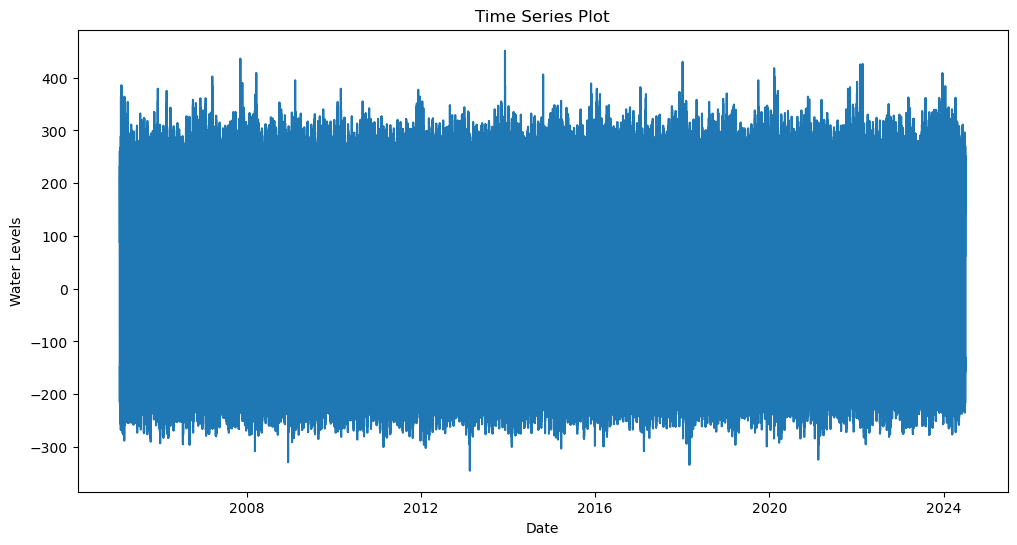

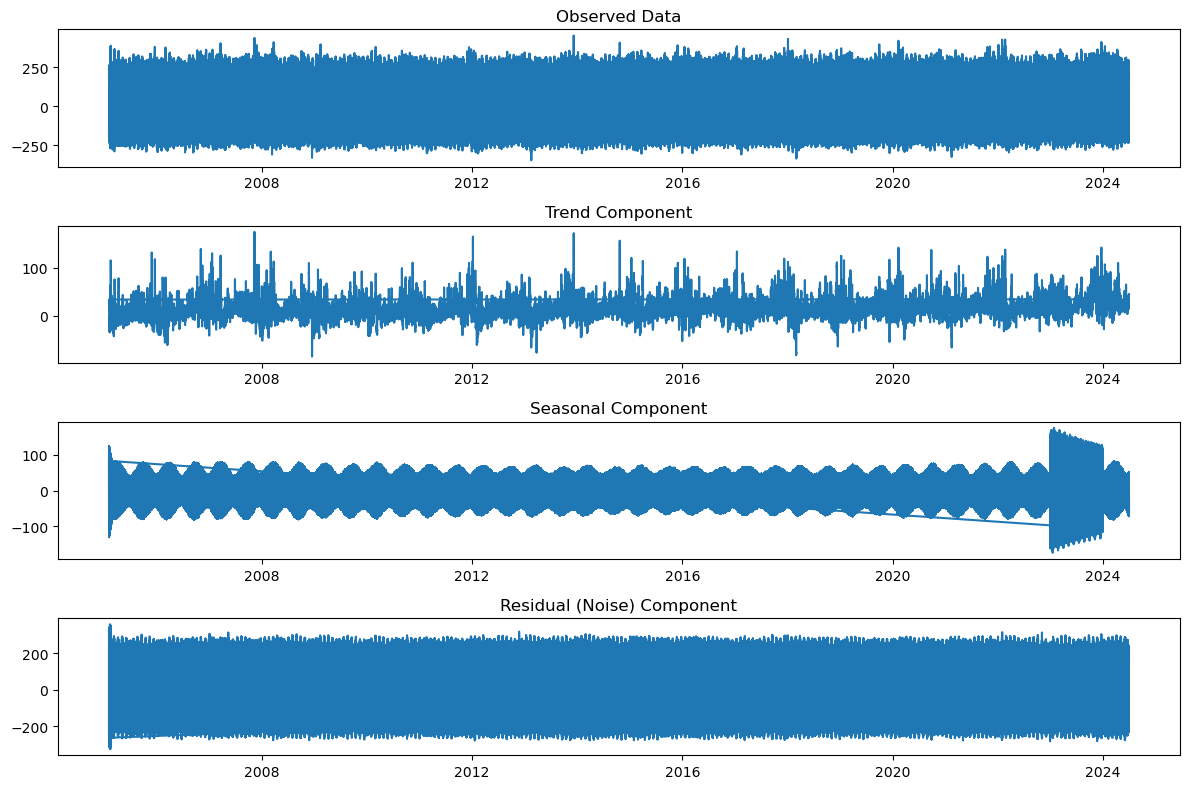

<Figure size 1000x600 with 0 Axes>

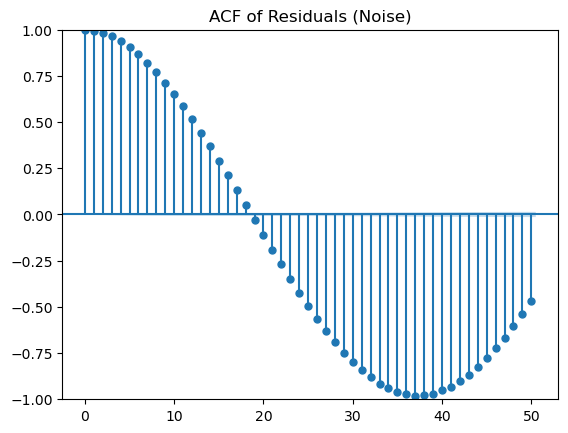


Summary of Decomposition:
No significant missing values in trend component.
Seasonality is present in the data.
Noise is present in the data.


In [4]:

# Check if the series is stationary using the ADF test (Dickey-Fuller)
adf_result = adfuller(train_df)
print(f'p-value: {adf_result[1]}')
if adf_result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")


# Plot the data to visually inspect
plt.figure(figsize=(12, 6))
plt.plot(df)
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Water Levels')
plt.show()

# Decompose the time series using STL (Seasonal and Trend decomposition using Loess)
#TODO: look into this more
stl = STL(df, seasonal=73, period=144) # Seasonality of twice daily (tide)
result = stl.fit()

# Plot the decomposed components (Trend, Seasonal, Residual)
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(result.observed)
plt.title('Observed Data')

plt.subplot(412)
plt.plot(result.trend)
plt.title('Trend Component')

plt.subplot(413)
plt.plot(result.seasonal)
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(result.resid)
plt.title('Residual (Noise) Component')

plt.tight_layout()
plt.show()

# Check for autocorrelation in the residuals (Noise)
plt.figure(figsize=(10, 6))
plot_acf(result.resid.dropna(), lags=50)  # Plot ACF of residuals
plt.title('ACF of Residuals (Noise)')
plt.show()

# Summarize findings
print("\nSummary of Decomposition:")
if result.trend.isnull().sum() > 0:
    print("Trend is present, but some data points have missing values due to moving window.")
else:
    print("No significant missing values in trend component.")
    
if np.abs(result.seasonal).mean() > 0:
    print("Seasonality is present in the data.")
else:
    print("No clear seasonality detected.")

if np.abs(result.resid).mean() > 0:
    print("Noise is present in the data.")
else:
    print("The data is relatively clean with minimal noise.")

### Facebook Prophet

In [5]:
# Create dataframe for prophet to use for predictions

# Start date and end date for 2024
start_date = '2024-01-01 00:00:00'
end_date = '2024-12-31 23:59:59'

# Create a datetime range for every 10 minutes in 2024
future_dates = pd.date_range(start=start_date, end=end_date, freq='10min')

# Create the future DataFrame for 2024 with NaN values for 'y'
future_df = pd.DataFrame(future_dates, columns=['ds'])

# Set 'y' column to NaN (Prophet will predict these values)
future_df['y'] = np.nan

# Check the first few rows of the future dataframe
print(future_df.head())
print(future_df.tail())


                   ds   y
0 2024-01-01 00:00:00 NaN
1 2024-01-01 00:10:00 NaN
2 2024-01-01 00:20:00 NaN
3 2024-01-01 00:30:00 NaN
4 2024-01-01 00:40:00 NaN
                       ds   y
52699 2024-12-31 23:10:00 NaN
52700 2024-12-31 23:20:00 NaN
52701 2024-12-31 23:30:00 NaN
52702 2024-12-31 23:40:00 NaN
52703 2024-12-31 23:50:00 NaN


In [6]:
# Prophet expects ds as a column, remove index
train_df = train_df.reset_index()
future_df = future_df.reset_index()

10:59:06 - cmdstanpy - INFO - Chain [1] start processing
11:02:20 - cmdstanpy - INFO - Chain [1] done processing


forecasting
                   ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2024-01-01 00:00:00  21.558416 -217.099749  165.237693    21.558416   
1 2024-01-01 00:10:00  21.558428 -205.794686  169.229596    21.558428   
2 2024-01-01 00:20:00  21.558440 -215.650971  179.861181    21.558440   
3 2024-01-01 00:30:00  21.558451 -225.250645  169.912248    21.558451   
4 2024-01-01 00:40:00  21.558463 -201.292936  166.767911    21.558463   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    21.558416      -42.566422            -42.566422            -42.566422   
1    21.558428      -39.835569            -39.835569            -39.835569   
2    21.558440      -36.800097            -36.800097            -36.800097   
3    21.558451      -33.482301            -33.482301            -33.482301   
4    21.558463      -29.906448            -29.906448            -29.906448   

       daily  ...    weekly  weekly_lower  weekly_upper    yearly  \
0 -44.36049

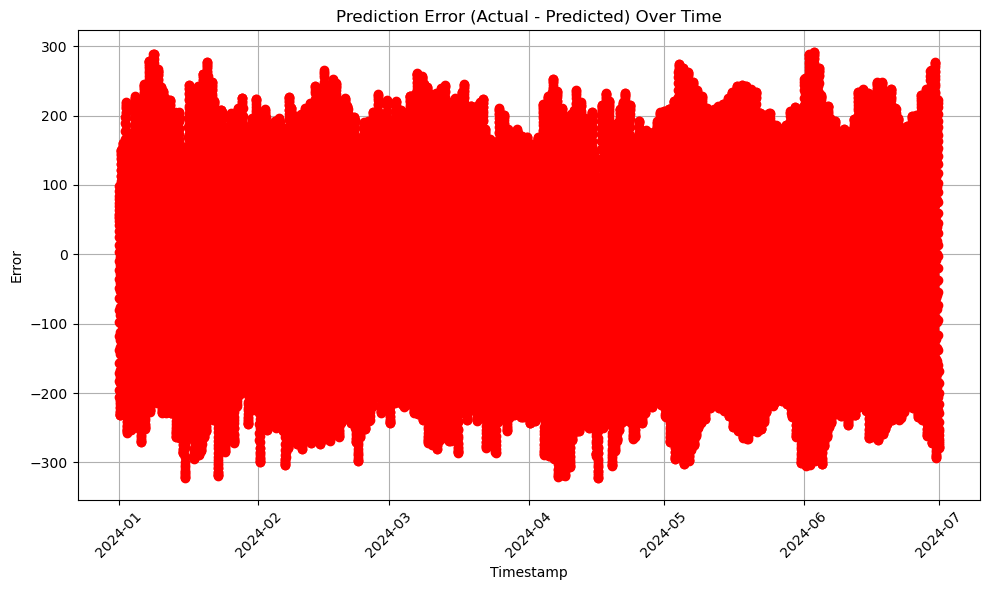

done


In [7]:
# model = Prophet(holidays=holidays)  # TODO: add holidays
model = Prophet()
model.fit(train_df)

print("forecasting")
forecast = model.predict(future_df)
print(forecast.head())


# # Plot the trend and seasonality components
# model.plot_components(forecast)
# plt.show()

# Plot the residuals
import matplotlib.pyplot as plt

# Merge forecast and test data on 'ds' (timestamp) to compare actual vs predicted values
merged_df = forecast[['ds', 'yhat']].merge(test_df, left_on='ds', right_index=True, how='inner')

# Calculate error (difference between actual and predicted values)
merged_df['error'] = merged_df['yhat'] - merged_df['y']

# Plot the error over time
plt.figure(figsize=(10, 6))
plt.plot(merged_df['ds'].to_numpy(), merged_df['error'].to_numpy(), marker='o', linestyle='-', color='red')
plt.title('Prediction Error (Actual - Predicted) Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Error')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("done")

# Rename the columns of test_df to match the format Prophet expects
test_df = test_df.copy()
test_df.rename(columns={'timestamp': 'ds', 'value': 'y'}, inplace=True)

# Merge the forecast and test data on the 'ds' column (timestamp)
test_df_reset = test_df.reset_index()
forecast = forecast.reset_index()

In [8]:
test_df = test_df.reset_index()

   index                  ds      trend  yhat_lower  yhat_upper  trend_lower  \
0      0 2024-01-01 00:00:00  21.558416 -217.099749  165.237693    21.558416   
1      1 2024-01-01 00:10:00  21.558428 -205.794686  169.229596    21.558428   
2      2 2024-01-01 00:20:00  21.558440 -215.650971  179.861181    21.558440   
3      3 2024-01-01 00:30:00  21.558451 -225.250645  169.912248    21.558451   
4      4 2024-01-01 00:40:00  21.558463 -201.292936  166.767911    21.558463   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    21.558416      -42.566422            -42.566422            -42.566422   
1    21.558428      -39.835569            -39.835569            -39.835569   
2    21.558440      -36.800097            -36.800097            -36.800097   
3    21.558451      -33.482301            -33.482301            -33.482301   
4    21.558463      -29.906448            -29.906448            -29.906448   

   ...    weekly  weekly_lower  weekly_upper    ye

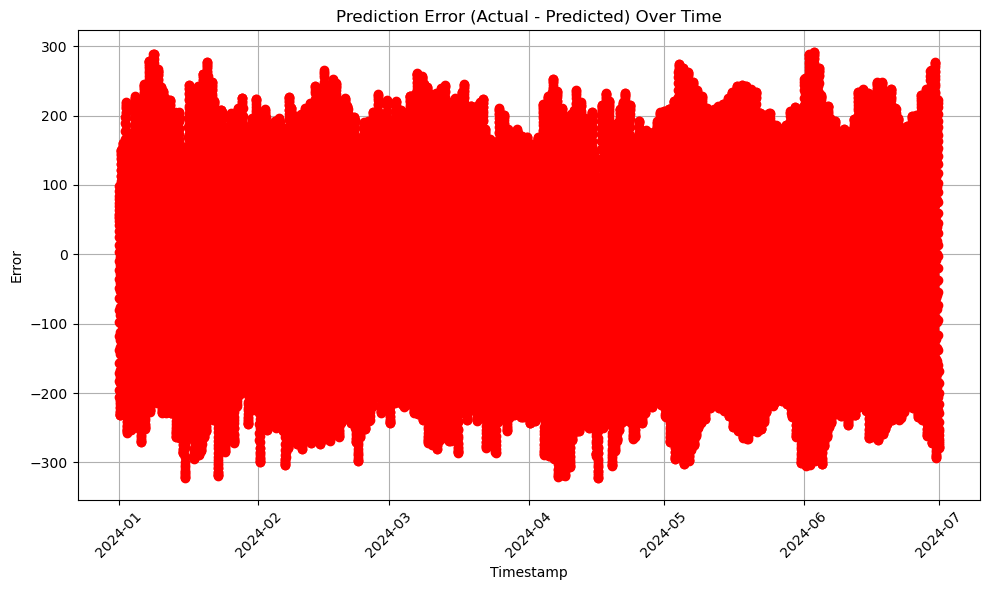

In [9]:
print(forecast.head())
print(test_df.head())

print(forecast.columns)
print(test_df.columns)


merged_df = forecast[['ds', 'yhat']].merge(test_df[['ds', 'y']], on='ds', how='inner')

# Calculate error
merged_df['error'] = merged_df['yhat'] - merged_df['y']

# Plot the error over time
plt.figure(figsize=(10, 6))
plt.plot(merged_df['ds'].to_numpy(), merged_df['error'].to_numpy(), marker='o', linestyle='-', color='red')
plt.title('Prediction Error (Actual - Predicted) Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Error')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#TODO: mean absolute error
#TODO: add "holiday" events (i.e. storms or things like that)

In [10]:

mae = np.mean(np.abs(merged_df['error']))
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 132.7385345116375


### Random forest model

In [11]:
df = df.reset_index()


In [12]:
df['ds'] = pd.to_datetime(df['ds'])
df['day_of_year'] = df['ds'].dt.dayofyear
df['month'] = df['ds'].dt.month
df['day_of_week'] = df['ds'].dt.dayofweek

# Use lag features (previous water level) for prediction
df['lag_1'] = df['y'].shift(1)
df['lag_2'] = df['y'].shift(2)
df['lag_3'] = df['y'].shift(3)

# Drop rows with missing lag values
df = df.dropna(subset=['lag_1', 'lag_2', 'lag_3'])

# Step 2: Feature Selection
# Features for the model
features = ['day_of_year', 'month', 'day_of_week', 'lag_1', 'lag_2', 'lag_3']
X = df[features]
y = df['y']

# Step 3: Train the model
# Split the data into train and test sets (train on data up to 2024, test on data after 2024)
train_data = df[df['ds'].dt.year < 2023]
test_df = df[df['ds'].dt.year == 2024]

X_train = train_data[features]
y_train = train_data['y']
X_test = test_df[features]
y_test = test_df['y']

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Step 4: Make predictions and evaluate the model
y_pred = rf_model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Output the result
print(f"Mean Absolute Error: {mae:.2f} cm")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f} cm")

Mean Absolute Error: 1.12 cm
Mean Squared Error: 2.35 cm


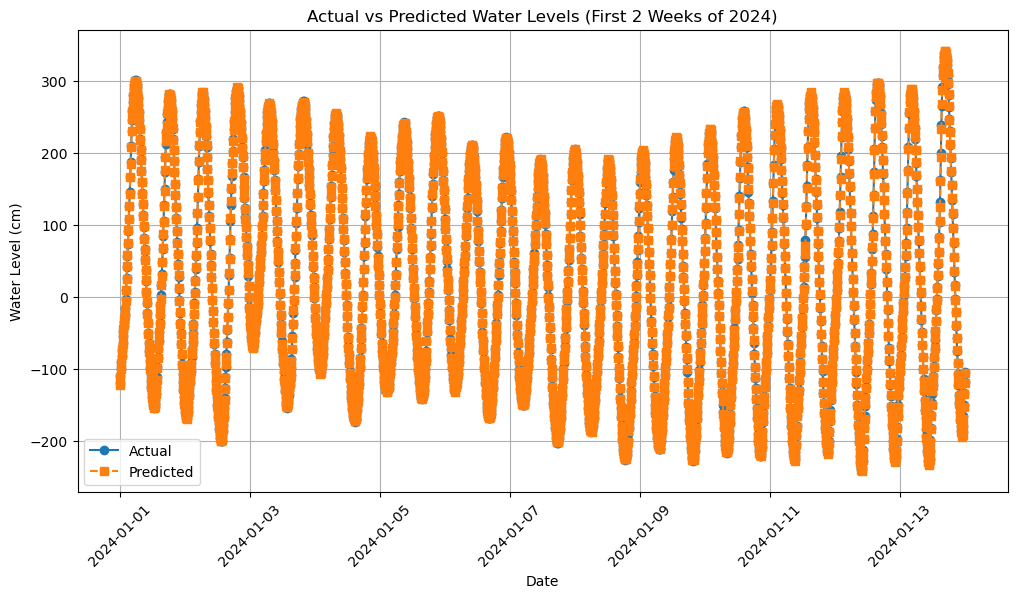

In [15]:
# Create a DataFrame for visualization
df_results = test_df.copy()
df_results['y_pred'] = y_pred

# Filter for the first 2 weeks of 2024
start_date = "2024-01-01"
end_date = "2024-01-14"
df_results_filtered = df_results[(df_results['ds'] >= start_date) & (df_results['ds'] <= end_date)]

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df_results_filtered['ds'].to_numpy(), df_results_filtered['y'].to_numpy(), label='Actual', marker='o', linestyle='-')
plt.plot(df_results_filtered['ds'].to_numpy(), df_results_filtered['y_pred'].to_numpy(), label='Predicted', marker='s', linestyle='--')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Water Level (cm)')
plt.title('Actual vs Predicted Water Levels (First 2 Weeks of 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()